In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
from invariance_kernels_2d import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 60
max_v = 10 
n_train = 5
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)
train_starting_position1 = [-35.04274277,-6.76724423,17.54967141,38.53874525, -46.41330999]
train_starting_position2 = [-38.8942861,-42.51860058,15.68678933, -21.96409073, 2.66426347]
train_starting_velocity1 = [-4.48414056, -6.84033471, -3.711912,5.25853915,3.07583679]
train_starting_velocity2 = [-6.65967739,0.06762814,0.39224133,8.5177379, 6.983022]

data2 = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[  6.5173148  -55.91507829  57.9372309   48.40198743 -46.08412969]
[ -6.6459755  -14.24441602  57.21187739  11.49518814  25.96169504]
[ 2.46367364  7.24190188 -2.39073576 -4.94125064 -0.27507024]
[ 9.66357864  4.48530939  3.38532653  5.18522774 -6.70796586]


In [3]:

scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
#scalerX = StandardScaler().fit(data2[0])
#scalerY = StandardScaler().fit(data2[1])
#scalerX = MinMaxScaler((-1,1)).fit(data2[0])
#scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (double_pendulum_dynamics1, double_pendulum_dynamics2)
jitter = 5e-4

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [4]:

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
#try:
n_neighbours =  40
print("known")
kernel_known = get_invariance_kernel_2D(DoublePendulumLocalInvariance, 1.5, 6, 0, 0.5, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())

polynomial_degree = 3
print("learnt")

kernel = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_model=known)
print(model.log_marginal_likelihood().numpy())

moi
783.4573752236912
known
838.9387369888914
learnt
876.3626939785536


In [5]:
kernel

name,class,transform,prior,trainable,shape,dtype,value
PolynomialLocalInvariance2D.Ka1.variance,Parameter,Sigmoid,,True,(),float64,9.991342316156405
PolynomialLocalInvariance2D.Ka1.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[0.88076517, 1.02074884, 4.92927703..."
PolynomialLocalInvariance2D.Ka2.variance,Parameter,Sigmoid,,True,(),float64,2.0777783962161998
PolynomialLocalInvariance2D.Ka2.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[0.6936253, 0.82091391, 9.99950208..."
PolynomialLocalInvariance2D.Kv1.variance,Parameter,Sigmoid,,True,(),float64,4.111937604889345
PolynomialLocalInvariance2D.Kv1.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[9.99943586, 9.99856444, 3.0918014..."
PolynomialLocalInvariance2D.Kv2.variance,Parameter,Sigmoid,,True,(),float64,0.8427525136213432
PolynomialLocalInvariance2D.Kv2.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[9.99993638, 9.93406754, 9.99540312..."
PolynomialLocalInvariance2D.poly,Parameter,Sigmoid,,True,"(4, 35)",float64,"[[2.16212953e-04, -1.12526783e-03, 9.24264507e-04..."


In [6]:
eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

def energy(X):
    return -2*np.cos(X[:,0])-np.cos(X[:,1])+0.5*tf.square(X[:,2])+0.5*(tf.square(X[:,2])+tf.square(X[:,3])+2*X[:,2]*X[:,3]*np.cos(X[:,0]-X[:,1]))
lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()
for i in range(10):
    print(i)
    test_starting_position1 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_position2 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity1 = np.radians(np.random.uniform(-max_v, max_v))
    test_starting_velocity2 = np.radians(np.random.uniform(-max_v, max_v))
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
#    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    print(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_learnt[0])

0
0.0003776555038211877
0.00028266430418810647
0.0002337593787974372
1
0.0005990634909797909
9.571803140664095e-05
0.000575211346349324g
2
0.026462879654194506
0.00024933631078301647
0.008558858013696331g
3
0.00024843356865190627
0.00043425736734251487
0.0012046290039129219
4
0.00588503012708581
0.0010145064479808947
0.0017381614929464562
5
0.00047780973839024824
0.0005780597427964971
0.0013947206467950887
6
0.0029272877019851356
0.0013113560841330485
0.0017844231330848795
7
0.0005204990602718137
8.810386006600453e-05
0.00011721238044844077
8
0.00033817927230117437
9.829274773814164e-05
0.0008896484478519485
9
0.0017556816926531749
0.00029218905472065356
0.001255985816838474g


In [7]:

print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_known),".4f")+" & "+format((np.mean(eva_future_learnt)),".4f")+ ' \\\\')

Log Marginal Likelihood & 783.46 & 838.41 & 869.09 &  \\
MSE & 0.0040 & 0.0004 & 0.0018 \\


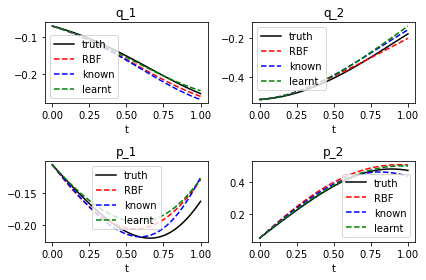

In [15]:
import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_known[4][:,0],label="truth", color="black")
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].set_title("q_1")
axs[0][0].set_xlabel("t")
axs[0][0].legend()

axs[0][1].plot(t,evaluate_known[4][:,1],label="truth", color="black")
axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].set_title("q_2")
axs[0][1].set_xlabel("t")
axs[0][1].legend()

axs[1][0].plot(t,evaluate_known[4][:,2],label="truth", color="black")
axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].set_title("p_1")
axs[1][0].set_xlabel("t")
axs[1][0].legend()

axs[1][1].plot(t,evaluate_known[4][:,3],label="truth", color="black")
axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].set_title("p_2")
axs[1][1].set_xlabel("t")
axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()
#plt.savefig("figures/double_pendulum_predicted.pdf")


Text(0, 0.5, 'E')

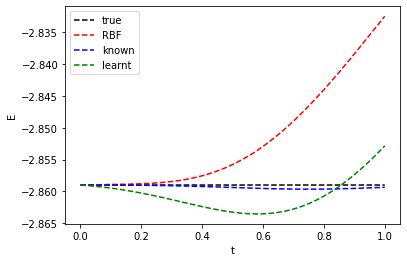

In [16]:
fig, ax = plt.subplots()
plt.plot(t, evaluate_learnt[5], "--",label="true", color="black")
plt.plot(t, evaluate_moi[6], "--",label="RBF", color="red")
plt.plot(t, evaluate_known[6], "--",label="known", color="blue")
plt.plot(t, evaluate_learnt[6], "--",label="learnt", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/double_pendulum_energy.pdf")

In [5]:

from scipy.stats import spearmanr, pearsonr
def energy(X):
    return -2*np.cos(X[:,0])-np.cos(X[:,1])+0.5*tf.square(X[:,2])+0.5*(tf.square(X[:,2])+tf.square(X[:,3])+2*X[:,2]*X[:,3]*np.cos(X[:,0]-X[:,1]))

n_neighbours = 40


kernel = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
model_fixed = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known, fixed=True)

print(model_fixed.log_marginal_likelihood().numpy())


polynomial_degree = 3
print("learnt")
test_starting_position1 = np.radians(np.random.uniform(-max_x, max_x))
test_starting_position2 = np.radians(np.random.uniform(-max_x, max_x))
test_starting_velocity1 = np.radians(np.random.uniform(-max_v, max_v))
test_starting_velocity2 = np.radians(np.random.uniform(-max_v, max_v))
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)

evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_moi[0])
evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_known[0])

evaluate_learnt_fixed = evaluate_model_future_2D(model_fixed, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt_fixed[0])

evaluate_learnt_free = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt_free[0])


grids_lml = []
grids_eva = []
for i in range(50):
    print(i)
    kernel_grid = get_paramertised_invariance_kernel_2D(PolynomialLocalInvariance2D, 1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
    kernel_grid.poly = gpflow.Parameter(0.1*np.random.normal(size=kernel_grid.poly.shape), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), trainable=False, prior=tfp.distributions.Laplace(to_default_float(0),(0.1)), name="poly")
    model_grid = get_GPR_model_2D(kernel_grid, mean, data, iterations=1000, old_model=known, fixed=True)
    print(model_grid.log_marginal_likelihood().numpy())

    evaluate_learnt_grid = evaluate_model_future_2D(model_grid, test_starting, dynamics, time_setting, scalers, energy)
    print(evaluate_learnt_grid[0])
    grids_eva.append(evaluate_learnt_grid[0])
    grids_lml.append(model_grid.log_marginal_likelihood().numpy())
    if i>=2:
        print(pearsonr(grids_lml, grids_eva))
        print(spearmanr(grids_lml, grids_eva))


133.6712112824049
learnt
0.030338295737560597
0.004262948879235944g
0.07551137610548159gg
0.015920458615895017g
0
-2198.731683330114
0.12078323340968312gg
1
-3337.3039744144794
0.08673062280617364gg
2
-3341.270012920601
0.10236651327297608gg
(0.8872270547024759, 0.30525731347080093)
SpearmanrResult(correlation=0.5, pvalue=0.6666666666666667)
3
-3990.040335187271
0.1158085083435664ggg
(0.30032474694798306, 0.6996752530520169)
SpearmanrResult(correlation=0.19999999999999998, pvalue=0.8)
4
-3516.4033292599233
0.1478468191695942ggg
(0.005216360707379009, 0.9933583533883533)
SpearmanrResult(correlation=-0.19999999999999998, pvalue=0.747060078104662)
5
-4491.4817492115435
0.05811688327343944gg
(0.4857826330988292, 0.32864470100179927)
SpearmanrResult(correlation=0.3142857142857143, pvalue=0.5440932944606414)
6
-5412.409500400653
0.0745063080928944ggg
(0.5867340436301561, 0.16612239378605528)
SpearmanrResult(correlation=0.5357142857142858, pvalue=0.21521745567801273)
7
-5670.919603761752
0.18

/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


0.08390917504339307
(-0.14949986942550414, 0.3327552369737812)
SpearmanrResult(correlation=-0.25708245243128963, pvalue=0.09205682566978823)
44
-5385.776432367643


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:273: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


0.3091407092365894gg
(-0.1720713128805025, 0.2583654972483841)
SpearmanrResult(correlation=-0.28168642951251643, pvalue=0.06084861079298298)
45
-3318.8323732479694
0.09628361811119496gg
(-0.1768931851699522, 0.23958199651966516)
SpearmanrResult(correlation=-0.28510638297872337, pvalue=0.054789712792988415)
46
-2871.598375378976
0.3109910872567159ggg
(-0.13494711365836928, 0.3657912162515957)
SpearmanrResult(correlation=-0.23716466234967626, pvalue=0.10846491991697929)
47
-5298.285592138709
0.20601879289433533gg
(-0.14353910431626044, 0.3304010028054397)
SpearmanrResult(correlation=-0.2534737299174989, pvalue=0.08215074087780629)
48
-5636.406790600791
0.08255983520615047gg
(-0.13015082544317302, 0.37274883387251995)
SpearmanrResult(correlation=-0.23306122448979588, pvalue=0.10705054595688764)
49
-3044.4093186019654
0.06287136762216491gg
(-0.1413953690447183, 0.32735259267645905)
SpearmanrResult(correlation=-0.24773109243697478, pvalue=0.08281716793829029)


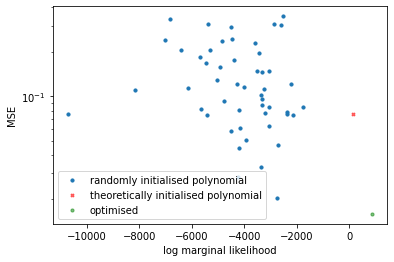

In [6]:

plt.scatter(grids_lml, grids_eva, s=10, label="randomly initialised polynomial")
plt.scatter(model_fixed.log_marginal_likelihood().numpy(), evaluate_learnt_fixed[0],marker="X",s=10, color="red", label="theoretically initialised polynomial", alpha=0.5)
plt.scatter(model.log_marginal_likelihood().numpy(), evaluate_learnt_free[0], s=10, color="green", label="optimised", alpha=0.5)
plt.yscale("log")
plt.xlabel("log marginal likelihood")
plt.ylabel("MSE")
plt.legend()
plt.savefig("figures/double_pendulum_polynomial.pdf")

In [7]:

from scipy.stats import spearmanr, pearsonr
print(spearmanr(grids_lml, (grids_eva)))
print(pearsonr(grids_lml, (grids_eva)))

SpearmanrResult(correlation=-0.24773109243697478, pvalue=0.08281716793829029)
(-0.1413953690447183, 0.32735259267645905)


In [26]:
min(grids_eva)

0.0006001384695890139